# **PCA and EM**
---

#### Initialize data and parameters

In [55]:
import torch
import torch.distributions as ds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

x = torch.load('data.pt')
theta = torch.tensor([1/3, 1/3, 1/3])
betas = torch.tensor([1/3, 2/3, 1])
alpha = 5

In [9]:
# uncomment to use numpy
import numpy as np
from scipy.stats import gamma
x = x.numpy()
theta = theta.numpy()
betas = betas.numpy()

In [10]:
def e_step(theta, betas):
    pdf_vals = gamma.pdf(x, a=alpha, scale=1/betas)
    weighted_pdf_vals = pdf_vals * theta
    denom = weighted_pdf_vals.sum(axis=1, keepdims=True)
    q = weighted_pdf_vals / denom
    return q

In [11]:
def m_step(q):
    N = q.shape[0]
    K = q.shape[1]
    theta_hat = np.sum(q, axis=0) / N
    beta_hats = np.zeros(K)
    for k in range(K):
        num = np.sum(q[:, k] * alpha)
        denom = np.sum(q[:, k] * x[:, 0])
        beta_hats[k] = num / denom
    return theta_hat, beta_hats

In [13]:
def log_px(x, theta, betas):
    x = x.reshape(-1, 1)
    pdf_values = np.array([gamma(a=alpha, scale=1/beta).pdf(x) for beta in betas]).T
    w_sums = np.dot(pdf_values, theta)
    log_probs = np.log(w_sums)
    return log_probs

def log_likelihood(theta, betas):
    return log_px(x, theta, betas).sum()

In [14]:
def run_em(theta, betas, iterations=1000):
    for _ in range(iterations):
        q = e_step(theta, betas)
        theta, betas = m_step(q)
    return theta, betas


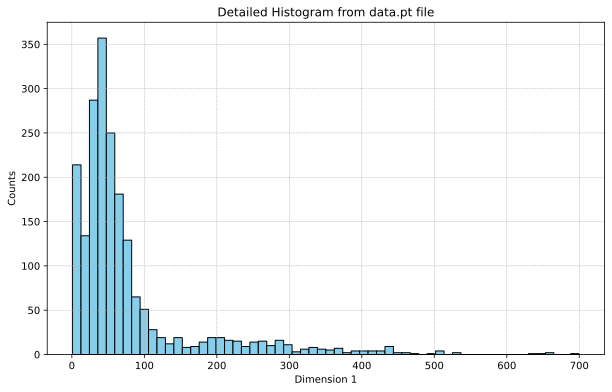

In [22]:
# plot histogram from the data.pt file
data = torch.load('data.pt')
plt.figure(figsize=(10, 6))
if data.dim() > 1 and data.size(1) > 1:
    plt.hist2d(data[:, 0].numpy(), data[:, 1].numpy(), bins=60, cmap='viridis')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(label='Counts in bin')
else:
    plt.hist(data.numpy(), bins=60, color='skyblue', edgecolor='black')
    plt.xlabel('Dimension 1')
    plt.ylabel('Counts')
plt.title('Detailed Histogram from data.pt file')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


#### Initialize data:

In [45]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
# x = x.numpy()              # uncomment to use numpy (optional)

In [46]:
x_mean = torch.mean(x, dim=0)
x_centered = x - x_mean

# def pca(x, n_comps=500):
#     U, S, V_t = torch.linalg.svd(x_centered)
#     eigvals = (S**2)
#     top_eigvals = eigvals[:n_comps]
#     V = V_t.T
#     top_pcomps = V[:, :n_comps]
#     return top_eigvals, top_pcomps

def pca (x, n_comps = 500 ):
    U, S, V_t = torch . linalg . svd ( x_centered )
    eigvals = (S ** 2)
    top_eigvals = eigvals [: n_comps ]
    V = V_t .T
    top_pcomps = V[:, : n_comps ]
    return top_eigvals , top_pcomps

In [47]:
def calc_cfvs(eigvals):
    # frac_vars = eigvals / torch.sum(eigvals)
    # cum_frac_vars = torch.cumsum(frac_vars, dim=0)
    # return cum_frac_vars
    frac_vars = eigvals / torch .sum( eigvals )
    cum_frac_vars = torch . cumsum ( frac_vars , dim =0)
    return cum_frac_vars

In [48]:
def calc_errs(x, pcomps):
    # x_projected = torch.mm(x_centered, pcomps)
    # x_reconstructed = torch.mm(x_projected, pcomps.T) + x_mean
    # err_mean = torch.norm(x_centered, p=2, dim=1).pow(2).mean()
    # err_pcomp = torch.norm(x_centered - x_reconstructed, p=2, dim=1).pow(2).mean()
    # return err_mean, err_pcomp
    x_projected = torch .mm( x_centered , pcomps )
    x_reconstructed = torch .mm( x_projected , pcomps .t()) + x_mean
    err_mean = torch . norm (x - x_mean , p=2, dim=1). pow (2). mean ()
    err_pcomp = torch . norm ( x_centered - x_reconstructed , p=2, dim=1). pow (2). mean ()
    return err_mean , err_pcomp

In [53]:
def plot_pic(pic, ax, title='', img_shape=(28, 28)):
    ax.imshow(pic, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps, img_shape=(28, 28)):
    # Plot eigenvalues and cumulative fraction of variances
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('Cumulative Fraction of Variances')
    fig.savefig('p3_cfvs.pdf')

    # Plot mean image
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean.reshape(img_shape), ax, 'Mean')
    fig.savefig('p3_mean.pdf')

    # Plot the first 10 principal components
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        # Reshape each principal component into the specified image shape before plotting
        img = pcomps[:, i].reshape(img_shape)  # Adjusting the reshape operation
        plot_pic(img, axes.flat[i], title=f'PC {i}')
    fig.savefig('p3_pcomps.pdf')
